
<img src="blocks.png" width="480"> 


In [12]:
import sys ; sys.path.append("../") # osx
import cvlib

In [13]:
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from time import time

In [14]:
img = cv.imread('C:/GitHub/pythonPrograms/computerVision2023/clases/imagenes/cameraman_face.jpg', cv.IMREAD_GRAYSCALE)
#img = cv.imread('../im/Border Checkpoint Between Nepal & China.jpg', cv.IMREAD_GRAYSCALE)
img = cv.GaussianBlur(img,(5,5),0)
img.shape

(339, 338)

In [15]:
def build_blocks(img, n, m, verbose=False):
    """ Split an image into n,m blocks.
    Args:
        img (numpy.array): Image to split
        n (int): Number of row elements in mosaic
        m (int): Number of col elements in mosaic
    """
    
    assert len(img.shape)==2 #only grayscale images
    assert type(n) == int
    assert type(m) == int
    
    r, c = img.shape
    
    pixels_per_row = r//n
    pixels_per_col = c//m
    
    pixels_mod_rows = r%n
    pixels_mod_cols = c%m
    
    if verbose:
        print(pixels_per_row,pixels_per_col)
        print(pixels_mod_rows,pixels_mod_cols)
        
    images = []
    for i in range(n):
        row = []
        # check if last row
        if i==n-1:
            r_mod = pixels_mod_rows
        else:
            r_mod = 0
            
        for j in range(m):
            # check if last col
            if j==m-1:
                c_mod = pixels_mod_cols
            else:
                c_mod = 0
                
            I = i*pixels_per_row
            I_ = I + pixels_per_row + r_mod
            
            J = j*pixels_per_col
            J_ = J + pixels_per_col + c_mod
            
            block = img[I:I_, J:J_]
            row.append(block)
            
        images.append(row)
    
    return images


n = 2
m = 4
blocks = build_blocks(img,n,m,verbose=True)

169 84
1 2


In [16]:
t = 0
for i in range(n):
    for j in range(m):
        print("{0},{1} : {2}".format(i,j,blocks[i][j].shape))
        t += blocks[i][j].shape[0]*blocks[i][j].shape[1]

# validate number of pixels
t == img.shape[0]*img.shape[1]

0,0 : (169, 84)
0,1 : (169, 84)
0,2 : (169, 84)
0,3 : (169, 86)
1,0 : (170, 84)
1,1 : (170, 84)
1,2 : (170, 84)
1,3 : (170, 86)


True

In [17]:
blocks_list = []
for sublist in blocks:
    for item in sublist:
        blocks_list.append(item)

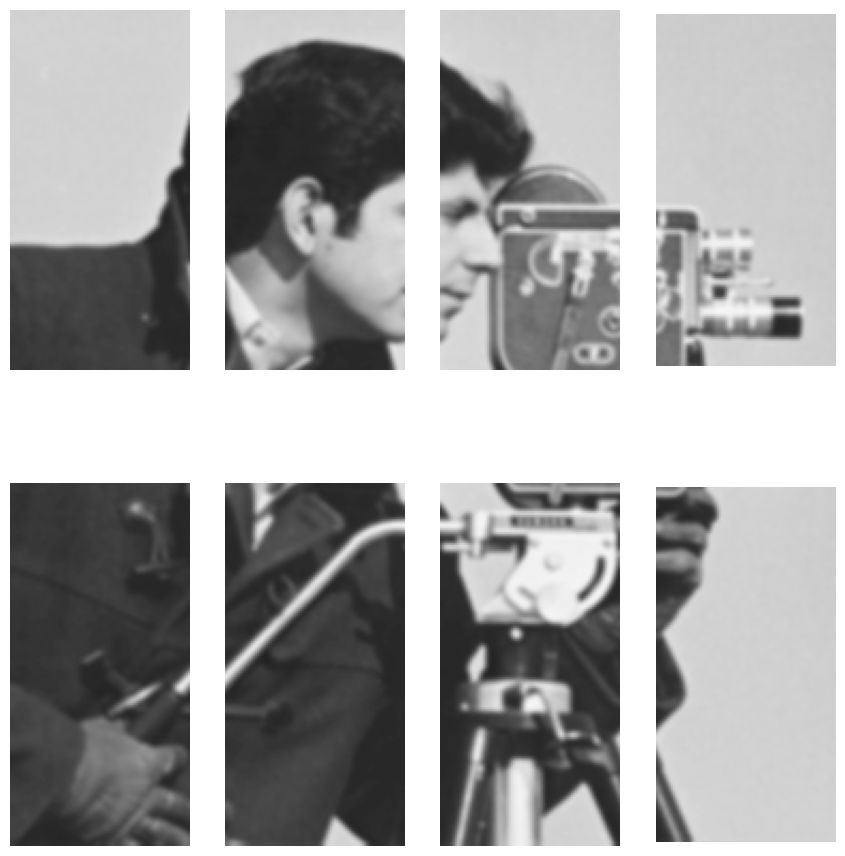

In [18]:
def mosaicview(blocks_list, n, m, filename=None):
    """
    """
    fig, axs = plt.subplots(n, m, figsize=(30, 30))
    axs = axs.flatten()
    for img, ax in zip(blocks_list, axs):
        ax.imshow(img, cmap=plt.cm.gray, vmin=0, vmax=255)
        ax.axis('off')
        plt.subplots_adjust(right=0.4, top=0.4)

    if filename != None:
        plt.savefig(filename, dpi=200, bbox_inches='tight')
    plt.show()


mosaicview(blocks_list,n,m)

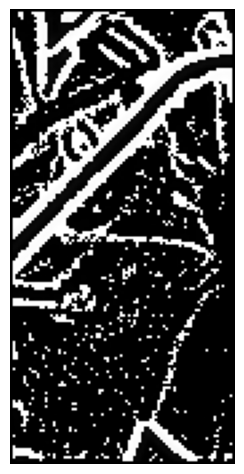

In [19]:
def apply_kernel_naive(img, kernel, queue=None):
    k_r, k_c = kernel.shape
    
    filtered = np.zeros_like(img,dtype=np.int32)
    
    R = k_r//2
    r, c = img.shape

    for i in range(R,r-R):
        for j in range(R,c-R):
            n = img[i-R:i+R+1, j-R:j+R+1]
            t = 0
            # apply kernel
            for x in range(k_r):
                for y in range(k_c):
                        t += n[x,y]*kernel[x,y]
            
            filtered[i,j] = t
            
    normalized = cv.normalize(filtered, 0, 255, cv.NORM_MINMAX)
    normalized_uint8 = normalized.astype(np.uint8)
    
    if queue == None:
        return normalized_uint8
    else:
        queue.put(normalized_uint8)



laplacian_k8 = np.array([[-1,-1,-1],
                        [-1, 8,-1],
                        [-1,-1,-1]])

laplacian_k = np.array([[ 0,-1, 0],
                        [-1, 4,-1],
                        [ 0,-1, 0]])

res = apply_kernel_naive(blocks[1][1],laplacian_k8)
cvlib.imgview(res)

# MULTIPROCESSING
Use the multiprocessing package to launch processes for each tile

In [20]:
# import multiprocessing as mp -- needs target function out of __main__ in jupyter notebook
import multiprocess as mp
import psutil

In [21]:
print(psutil.cpu_count(logical=False), psutil.cpu_count(logical=True))

4 8


In [22]:
output = mp.Queue()
num_processes = n*m
processes = [mp.Process(target=apply_kernel_naive, args=(blocks_list[x], laplacian_k8, output)) for x in range(num_processes)]

In [23]:
# Measure exec time
start_time = time()

for p in processes:
    p.start()
    
result = []
for ii in range(num_processes):
    result.append(output.get(True))

for p in processes:
    p.join()

print('-----------------------------------------------')
print(f'Executed in {time()- start_time} S.')
print('-----------------------------------------------')


(169, 84)


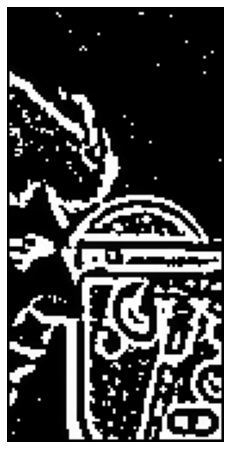

In [13]:
res = result[1]
print(res.shape)
cvlib.imgview(res)

In [14]:
# Measure exec time
start_time = time()

img_lappacian = apply_kernel_naive(img,laplacian_k8)

print('-----------------------------------------------')
print(f'Executed in {time()- start_time} S.')
print('-----------------------------------------------')

-----------------------------------------------
Executed in 0.3443741798400879 S.
-----------------------------------------------


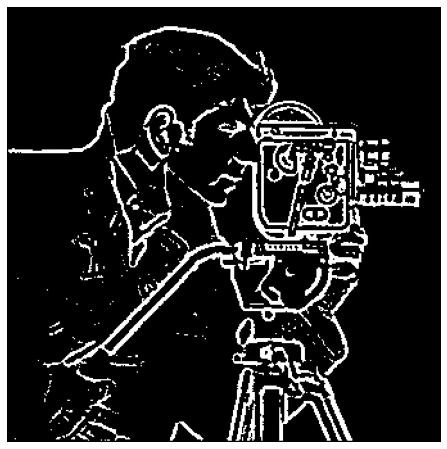

In [15]:
cvlib.imgview(img_lappacian)